Mounted at /content/drive
Loading datasets...
✅ Data loaded successfully

Preprocessing data...
Removed 4878 duplicate trades


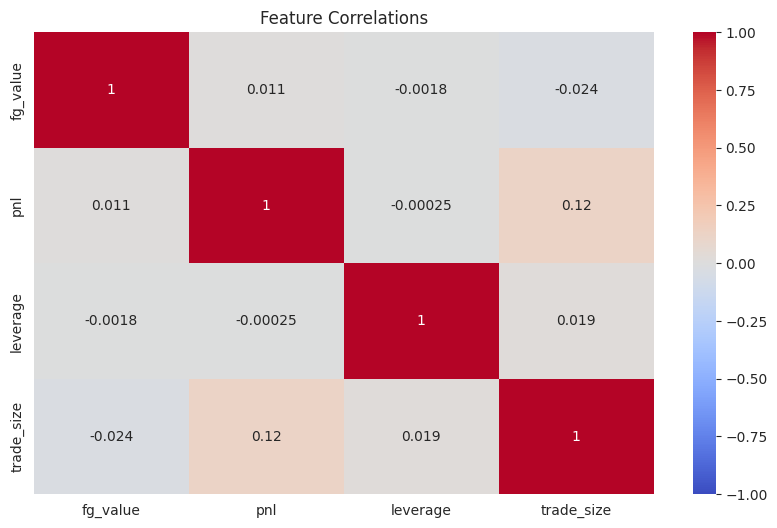


Analyzing trading behavior by sentiment...

Generating visualizations...


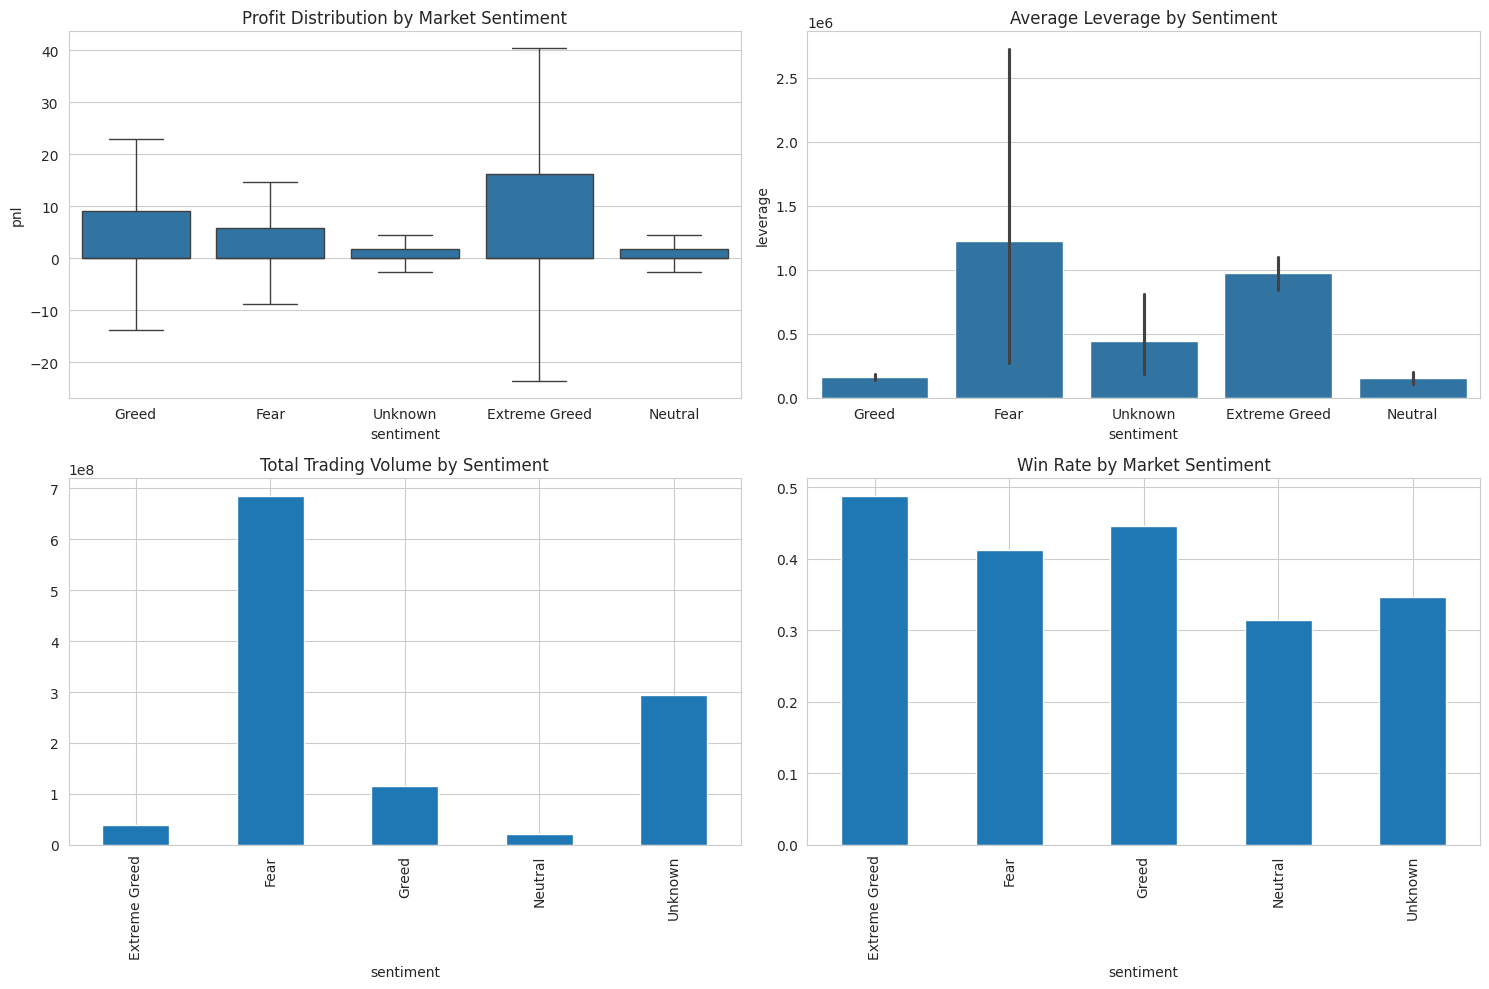

Profit Vs Leverage:


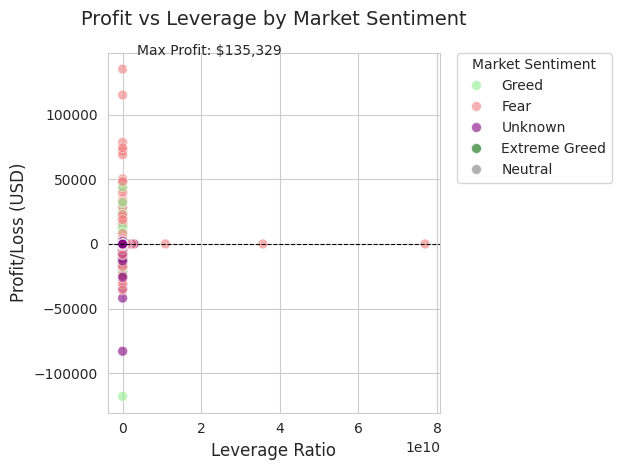


Saving results...

=== Key Insights ===
1. Most profitable sentiment: Greed
2. Highest leverage during: Fear
3. Largest volume during: Fear
4. Best risk-adjusted returns: count             Fear
mean     Extreme Greed
std              Greed
min            Neutral
25%      Extreme Greed
50%      Extreme Greed
75%              Greed
max              Greed
dtype: object
5. Worst risk-adjusted returns: count    Extreme Greed
mean           Unknown
std            Neutral
min               Fear
25%      Extreme Greed
50%      Extreme Greed
75%            Neutral
max            Neutral
dtype: object

✅ Analysis complete! Check the outputs folder for results.


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# ======================
# 1. SETUP & DATA LOADING
# ======================
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load datasets
print("Loading datasets...")
try:
    fg_data = pd.read_csv('/content/drive/MyDrive/ds_Narayana_Sathvika/csv_files/fear_greed_index.csv')
    trader_data = pd.read_csv('/content/drive/MyDrive/ds_Narayana_Sathvika/csv_files/trader_data.csv')
    print("✅ Data loaded successfully")
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    raise

# ======================
# 2. ROBUST PREPROCESSING
# ======================
print("\nPreprocessing data...")

# Create copies to avoid SettingWithCopyWarning
fg_data_clean = fg_data.copy()
trader_data_clean = trader_data.copy()

# A. Fear & Greed Data
fg_data_clean = fg_data_clean.rename(columns={
    'value': 'fg_value',
    'classification': 'sentiment'
})

# Convert date safely
fg_data_clean['date'] = pd.to_datetime(fg_data_clean['date'], errors='coerce')
fg_data_clean = fg_data_clean.dropna(subset=['date'])

# B. Trader Data - Handle timestamp conversion
def safe_timestamp_convert(ts):
    try:
        return pd.to_datetime(ts, unit='s')
    except:
        try:
            return pd.to_datetime(ts/1000, unit='s')
        except:
            return pd.NaT

# Apply conversions without chained assignment
timestamps = trader_data_clean['Timestamp'].apply(safe_timestamp_convert)
trader_data_clean = trader_data_clean.assign(timestamp=timestamps)
trader_data_clean = trader_data_clean.dropna(subset=['timestamp'])

# Create trade date for merging
trade_dates = pd.to_datetime(trader_data_clean['timestamp'].dt.date)
trader_data_clean = trader_data_clean.assign(trade_date=trade_dates)

# C. Data Cleaning
# Handle missing values safely
trader_data_clean['pnl'] = trader_data_clean['Closed PnL'].fillna(0)
position_sizes = trader_data_clean['Start Position'].replace(0, 0.001)
trader_data_clean = trader_data_clean.assign(position_size=position_sizes)
trade_sizes = trader_data_clean['Size USD'].fillna(trader_data_clean['Size USD'].median())
trader_data_clean = trader_data_clean.assign(trade_size=trade_sizes)

# Remove duplicates
initial_count = len(trader_data_clean)
trader_data_clean = trader_data_clean.drop_duplicates(subset=['Trade ID', 'Order ID'], keep='last')
print(f"Removed {initial_count - len(trader_data_clean)} duplicate trades")

# Calculate metrics safely
leverage = np.where(
    trader_data_clean['position_size'] > 0,
    trader_data_clean['trade_size'] / trader_data_clean['position_size'],
    1
)
trader_data_clean = trader_data_clean.assign(leverage=leverage)
trader_data_clean = trader_data_clean.assign(profitability=trader_data_clean['pnl'] > 0)

# ======================
# 3. MERGE DATASETS
# ======================
merged = pd.merge(
    trader_data_clean,
    fg_data_clean,
    left_on='trade_date',
    right_on='date',
    how='left'
).fillna({'sentiment': 'Unknown'})

#Feature Correlations
plt.figure(figsize=(10,6))
sns.heatmap(
    merged[['fg_value','pnl','leverage','trade_size']].corr(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title('Feature Correlations')
plt.savefig('/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/correlations.png')
plt.show()

# ======================
# 4. ANALYSIS & VISUALIZATION
# ======================
print("\nAnalyzing trading behavior by sentiment...")

# Core metrics
metrics = merged.groupby('sentiment').agg({
    'pnl': ['mean', 'median', 'std', 'count'],
    'leverage': 'mean',
    'trade_size': 'sum',
    'profitability': 'mean'
}).round(2)

# Risk analysis
merged = merged.assign(
    risk_adjusted_return=merged['pnl'] / merged['leverage'].replace(0, 1)
)
risk_metrics = merged.groupby('sentiment')['risk_adjusted_return'].describe()

# Visualization
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 10))

# 1. Profitability
plt.subplot(2, 2, 1)
sns.boxplot(data=merged, x='sentiment', y='pnl', showfliers=False)
plt.title('Profit Distribution by Market Sentiment')

# 2. Leverage
plt.subplot(2, 2, 2)
sns.barplot(data=merged, x='sentiment', y='leverage', estimator=np.mean)
plt.title('Average Leverage by Sentiment')

# 3. Volume
plt.subplot(2, 2, 3)
merged.groupby('sentiment')['trade_size'].sum().plot(kind='bar')
plt.title('Total Trading Volume by Sentiment')

# 4. Win Rate
plt.subplot(2, 2, 4)
merged.groupby('sentiment')['profitability'].mean().plot(kind='bar')
plt.title('Win Rate by Market Sentiment')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/core_analysis.png')
plt.show()


#PROFIT Vs LEVERAGE
# Define a complete palette for all sentiment categories
print("Profit Vs Leverage:")
sentiment_palette = {
    'Extreme Fear': 'darkred',
    'Fear': 'lightcoral',
    'Neutral': 'gray',
    'Greed': 'lightgreen',
    'Extreme Greed': 'darkgreen',
    'Unknown': 'purple'  # For any unexpected categories
}

# Create the plot
scatter = sns.scatterplot(
    data=merged,
    x='leverage',
    y='pnl',
    hue='sentiment',
    palette=sentiment_palette,
    alpha=0.6,
    s=50  # Adjust point size
)

plt.title('Profit vs Leverage by Market Sentiment', pad=20, fontsize=14)
plt.xlabel('Leverage Ratio', fontsize=12)
plt.ylabel('Profit/Loss (USD)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Improve legend
plt.legend(
    title='Market Sentiment',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

# Add annotations for interesting points
if not merged.empty:
    max_profit = merged.loc[merged['pnl'].idxmax()]
    plt.annotate(
        f"Max Profit: ${max_profit['pnl']:,.0f}",
        xy=(max_profit['leverage'], max_profit['pnl']),
        xytext=(10, 10),
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->")
    )

plt.tight_layout()
plt.savefig(
    '/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/profit_vs_leverage.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#Stratgies
strategies = {
    'Extreme Greed (value > 75)': "Reduce positions by 30%, tighten stop-losses",
    'Greed (50-75)': "Take partial profits at 5% gains",
    'Neutral (30-50)': "Normal trading ranges",
    'Fear (15-30)': "Scale into positions gradually",
    'Extreme Fear (<15)': "Aggressive buying with 2x normal position size"
}


with open('/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/trading_strategies.txt', 'w') as f:
    for sentiment, strategy in strategies.items():
        f.write(f"{sentiment} Period Strategy: {strategy}\n")

# ======================
# 5. SAVE RESULTS
# ======================
print("\nSaving results...")
metrics.to_csv('/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/core_metrics.csv')
risk_metrics.to_csv('/content/drive/MyDrive/ds_Narayana_Sathvika/outputs/risk_metrics.csv')

# ======================
# 6. KEY INSIGHTS
# ======================
print("\n=== Key Insights ===")
print("1. Most profitable sentiment:", metrics[('pnl', 'mean')].idxmax())
print("2. Highest leverage during:", metrics[('leverage', 'mean')].idxmax())
print("3. Largest volume during:", metrics[('trade_size', 'sum')].idxmax())
print("4. Best risk-adjusted returns:", risk_metrics.idxmax())
print("5. Worst risk-adjusted returns:", risk_metrics.idxmin())
print("\n✅ Analysis complete! Check the outputs folder for results.")